## Experiment description - REAL data

REAL data. Most inputs to shaft outputs

Run interactively on the web at: 

### Inputs


(2, 'i_nat_gas_inj_kg_thm')

(3, 'i_nat_gas_t_k')

(4, 'i_o2_vol_perce')

(5, 'i_bf_windrate_nm3_hr')

(6, 'i_hb_moist_g_nm3')

(7, 'i_hot_blast_press_pa')

(8, 'i_hot_blast_temp_k')


### Outputs


(15, 'o_shaft_co_utiliz')

(17, 'o_shaft_top_gas_temp_c')

(18, 'o_shaft_press_drop_pa')

(19, 'o_shaft_coke_rate_kg_thm')

(22, 'o_shaft_co_v_perce')

(23, 'o_shaft_co2_v_perce')

(24, 'o_shaft_h2_v_perce')

(25, 'o_shaft_n2_v_perce')


In [1]:
################################################
##
## regression with DL for system control
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 200
batch_size = 64    ## 4096
learning_rate =  0.0001   ## 0.1    ## 0.01   ## 1e-5 

## probably needs adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

In [2]:
REAL_raw_data = pd.read_csv('REAL.6.2022.csv') 

In [3]:
headers_list = REAL_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['time', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'o_tuyere_exit_velocity_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_vol_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_cohes_zone_root_height_m', 'o_shaft_co_v_perce', 'o_shaft_co2_v_perce', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perce']
26
(0, 'time')
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')
(9, 'o_tuyere_exit_velocity_m_s')
(10, 'o_tuyere_t_k')
(11, 'o_raceway_flame_temp_k')
(12, 'o_raceway_coal_burn_perce')
(13, 'o_raceway_vol_m')
(14, 'o_raceway_depth_m')
(

/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/user/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


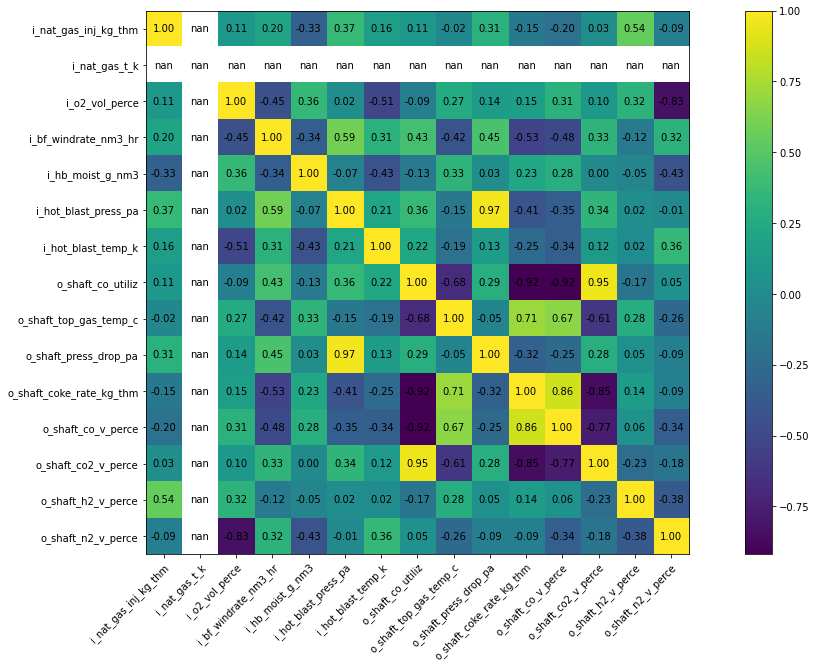

In [4]:
my_allInputs_tuyere_names = ['i_nat_gas_inj_kg_thm','i_nat_gas_t_k','i_o2_vol_perce',
                             'i_bf_windrate_nm3_hr','i_hb_moist_g_nm3','i_hot_blast_press_pa','i_hot_blast_temp_k',
                             'o_shaft_co_utiliz','o_shaft_top_gas_temp_c','o_shaft_press_drop_pa',
                             'o_shaft_coke_rate_kg_thm','o_shaft_co_v_perce','o_shaft_co2_v_perce',
                             'o_shaft_h2_v_perce','o_shaft_n2_v_perce']



cm = np.corrcoef(REAL_raw_data[my_allInputs_tuyere_names].values.T)
hm = heatmap(cm, row_names=my_allInputs_tuyere_names, column_names=my_allInputs_tuyere_names, figsize=(20, 10))
plt.show()

In [5]:
REALdata_np = REAL_raw_data.to_numpy()
print(REALdata_np)
print(REALdata_np.shape)

[[44409.             0.            19.07447517 ...     0.18729296
      0.0355921      0.54250139]
 [44409.00069        0.            19.03056499 ...     0.18731319
      0.03559234     0.54194257]
 [44409.00139        0.            18.96746451 ...     0.18733343
      0.03559259     0.54138374]
 ...
 [44500.99792        0.            39.54749868 ...     0.17403727
      0.04278425     0.54482702]
 [44500.99861        0.            39.55816822 ...     0.17407577
      0.04280375     0.54493011]
 [44500.99931        0.            39.67637414 ...     0.17419149
      0.04282324     0.54503319]]
(128281, 26)


In [6]:
#######################################################


def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss:', loss_fn(model(X_train_tr), y_train_tr))
    print('Training R**2:', r2_score(y_train_tr.numpy(), model(X_train_tr).detach().numpy()))
    
#######################################################

In [7]:
######################################################

'''

Inputs

(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')

Outputs
(15, 'o_shaft_co_utiliz')
(17, 'o_shaft_top_gas_temp_c')
(18, 'o_shaft_press_drop_pa')
(19, 'o_shaft_coke_rate_kg_thm')
(22, 'o_shaft_co_v_perce')
(23, 'o_shaft_co2_v_perce')
(24, 'o_shaft_h2_v_perce')
(25, 'o_shaft_n2_v_perce')


'''


#######################################################

input_indeces  = [2, 3, 4, 5, 6, 7, 8]
output_indeces = [15, 17, 18, 19, 22, 23, 24, 25 ]                            

#######################################################

X = REALdata_np[:, input_indeces]

y = REALdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(128281, 7)
(128281, 8)
(102624, 7)
(25657, 7)
(102624, 8)
(25657, 8)


In [8]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

In [9]:
###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon

X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations

In [10]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

In [11]:
#######################################################
## Linear Regression

class LinRegNet_SI(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(9, 8) 

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        return x

    
    

#############################################################


class DL_Net_SI(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(9, 16)
        self.act1    = nn.Tanh() 
        self.linear2 = nn.Linear(16, 10)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(10, 8)
        self.dropout = nn.Dropout(0.25)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        
        return x

      
#############################################################

In [12]:

'''

model = LinRegNet_SI(x_means, x_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit(N_EPOCHS, model, loss_fn, opt)

print('Test loss:', loss_fn(       model(X_test_tr),                    y_test_tr            ))
print('Testing R**2:', r2_score(   model(X_test_tr).detach().numpy(),   y_test_tr.numpy()    ))

'''


"\n\nmodel = LinRegNet_SI(x_means, x_deviations)\nopt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )\nloss_fn = F.mse_loss\n\nfit(N_EPOCHS, model, loss_fn, opt)\n\nprint('Test loss:', loss_fn(       model(X_test_tr),                    y_test_tr            ))\nprint('Testing R**2:', r2_score(   model(X_test_tr).detach().numpy(),   y_test_tr.numpy()    ))\n\n"

## Now scale outputs (y) as well

In [13]:
###################################################################
## for multiple regression outputs, normalize the y tensors too? 
## usually this is not done, but testing here

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

####################################################################

In [14]:
#######################################################


def fit_y_scaled(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################

In [15]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

In [16]:
#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(7, 8) 
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
    

#############################################################


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(7, 20)
        self.act1    = nn.ReLU()               ## nn.Tanh() 
        self.linear2 = nn.Linear(20, 20) 
        self.act2    = nn.ReLU()               ## nn.Tanh() 
        self.linear3 = nn.Linear(20, 8)
        self.dropout = nn.Dropout(0.25)
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
        
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################

In [17]:

'''

model = LinRegNet_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

'''

"\n\nmodel = LinRegNet_SIO(x_means, x_deviations, y_means, y_deviations)\nopt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )\nloss_fn = F.mse_loss\n\nfit_y_scaled(N_EPOCHS, model, loss_fn, opt)\n\npred_descaled, pred_scaled = model(X_test_tr)\nprint('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))\nprint('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))\nprint('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))\nprint('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))\n\n"

In [18]:



model = DL_Net_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))


Training loss: tensor(0.3819, grad_fn=<MseLossBackward0>)
Training R**2: 0.31203533445232423
Test loss - scaled: tensor(0.3768, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(12010049., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.29572141642599314
Testing R**2 - descaled: 0.2957214102416599


In [20]:

preds_descaled, preds_scaled = model(X_test_tr)
    
np_pred = preds_descaled.detach().numpy()              ## [0]
np_real = y_test_tr.detach().numpy()

print(np_pred.shape)
print(np_real.shape)



(25657, 8)
(25657, 8)


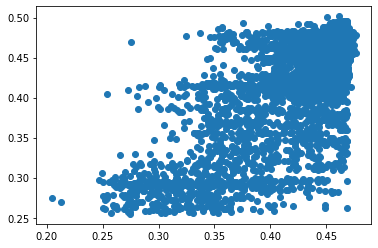

In [23]:
plt.scatter(np_pred[:,0], np_real[:,0])
plt.show()

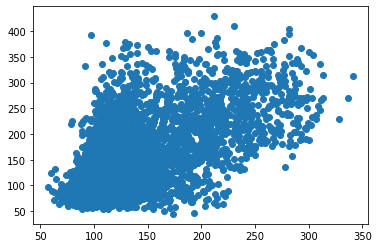

In [24]:
plt.scatter(np_pred[:,1], np_real[:,1])
plt.show()

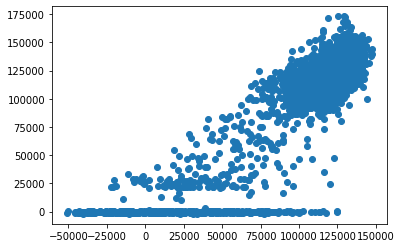

In [25]:
plt.scatter(np_pred[:,2], np_real[:,2])
plt.show()

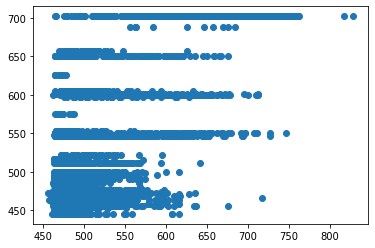

In [26]:
plt.scatter(np_pred[:,3], np_real[:,3])
plt.show()

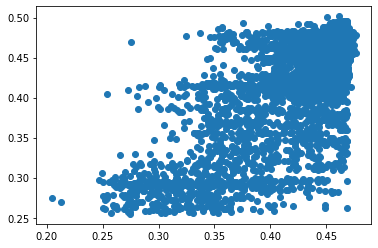

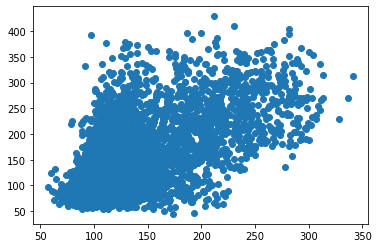

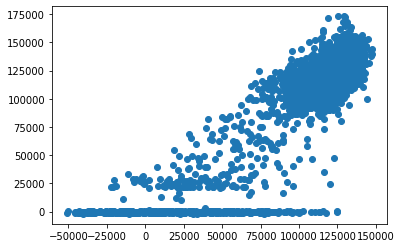

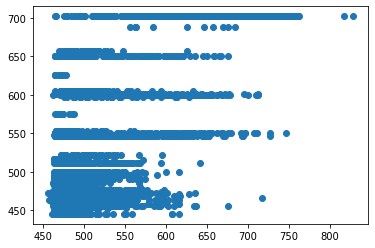

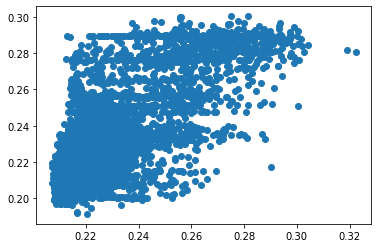

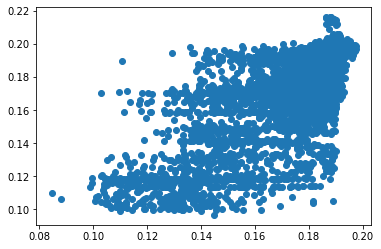

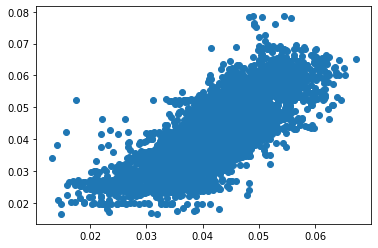

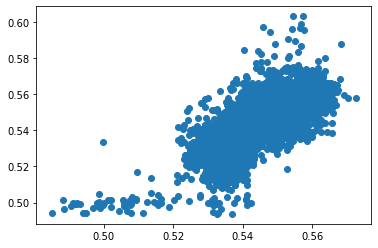

In [27]:
for i in range(8):
    plt.scatter(np_pred[:,i], np_real[:,i])
    plt.show()